In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# !pip install matplotlib
# !pip install seaborn

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv")
categ_df = df.select_dtypes(include=['object'])
numer_df =df.select_dtypes(exclude=['object'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Show features with at least some NaN values
null_counts = df.isnull().sum()
null_cols = []
##print("Percentage of null values in each column:\n")
for i in range(len(null_counts)):
    if null_counts[i] != 0:
        #print(null_counts.index[i], null_counts[i]/len(df))
        null_cols.append(null_counts.index[i])

In [5]:
#Features with too many NaN values, dropping them
#Also Id which has no correlation to houses, just a sample marker
df = df.drop(["Id","Alley","PoolQC","Fence","MiscFeature"],axis=1)

In [6]:
#Show features with at least some NaN values
null_counts = df.isnull().sum()
null_cols = []
#print("Number of null values in each column:\n")
for i in range(len(null_counts)):
    if null_counts[i] != 0:
        ##print(null_counts.index[i], null_counts[i])
        null_cols.append(null_counts.index[i])

In [7]:
#Columns that have the data description with an explanation for NaN values
##Basically indicates a lack of the feature is specified
valid_none_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType',
                'GarageFinish','GarageQual','FireplaceQu','GarageCond']

##Filling in with value 'None' to indicate for machine learning later
df[valid_none_cols]= df[valid_none_cols].fillna('None')

In [8]:
#Organizing the other features with NaN values into numerical and categorical features
#"Invalid" simply means the data description didn't specify NaN values

invalid_none_cols = np.array(null_cols)
#Fill with feature names in null_cols that only are NOT already in valid_none_cols
invalid_none_cols = invalid_none_cols[[i not in valid_none_cols for i in invalid_none_cols]]

#Splitting
invalid_none_categ = invalid_none_cols[[i in categ_df for i in invalid_none_cols]]
invalid_none_numer = invalid_none_cols[[i in numer_df for i in invalid_none_cols]]

#print(invalid_none_categ)
##print(invalid_none_numer)
#fill missing values for each column (using its own most frequent value)
#object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

### Dropping rows in MasVnrType and Electrical with NaN values

In [9]:
# According to data description file, the most columns uses 'NA' as 'No fireplace', 'No basement' and etc.
# However, MasVnrType/Electrical column contains 'NA' without any designation. Then it should be missing value.

bad_categ  = pd.concat([df['MasVnrType'],df['Electrical']],axis=1)
#Getting the particular rows in the df with NaN values
bad_rows = bad_categ[bad_categ.isna().any(axis=1)]
#Deleting these rows from the total df
df = df.drop(bad_rows.index)
#Categories without NaN descriptions should no longer have NaN values

In [10]:
##ADJUSTING NUMERICAL FEATURES
#For the most part these values can be assumed to indicate 0 when not filled with a number
##LotFrontage has many missing values, so all 0 wouldn't be great
#GarageYrBlt makes no sense with a value of 0. We'll change these two individually

#Adjusting LotFrontage by assuming the fill takes on the median value
#Perhaps this can be improved with comparisons to the LotArea feature?
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

#Adjusting GarageYrBlt based on the year the house was built

#plt.plot(df["GarageYrBlt"],df["YearBuilt"],"b.")
#plt.xticks(np.arange(min(df["GarageYrBlt"]),max(df["GarageYrBlt"]),20.0))
#plt.xlabel("Year Garage Built")
#plt.ylabel("Year Built")

#seems like the garage is built around the same year as the house or a bit later
#Again use the median value to fill in
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df['YearBuilt']-(df['GarageYrBlt']-df['YearBuilt']).median())

#Fill the rest of the null values to 0
for i in invalid_none_numer:
    df[i] = df[i].fillna(0)

## Removing Outliers based on Plots

In [11]:
# GrLivArea and GarageArea columns have relatively large correlation with the SalePrice.
# Use scatterplots to detect the outliers.
def visualDetectionOutlier(train_df):
    sp = train_df['SalePrice']
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(7,12))
    axes[0].scatter(x=train_df['GrLivArea'],y=sp, alpha=0.5)
    axes[0].set_title("GrLivArea vs SalePrice")
    axes[0].set_xlabel("sqft")
    axes[0].set_ylabel("Price")
    axes[1].scatter(x=train_df['GarageArea'],y=sp, alpha=0.5)
    axes[1].set_title("GarageArea vs SalePrice")
    axes[1].set_xlabel("sqft")
    axes[1].set_ylabel("Price")
    fig.tight_layout()
    plt.show()

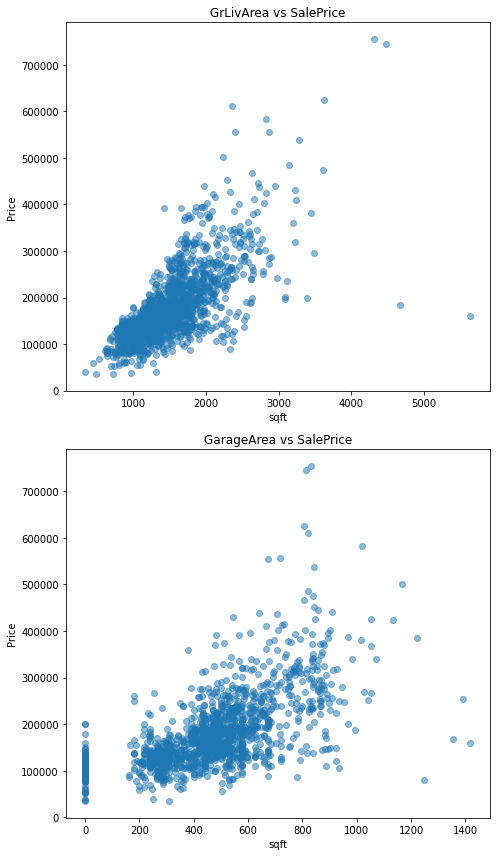

In [12]:
# Before removing outliers.
visualDetectionOutlier(df)

In [13]:
# [Plot 1: GrLivArea vs SalePrice] Bottom right two points look like outliers.
ol_plot1_bottomright = df.loc[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]
# [Plot 2: GarageArea vs SalePrice] Bottom right four points look like outliers.
ol_plot2_bottomright = df.loc[((df['GarageArea'] > 1200) & (df['SalePrice'] < 300000))]
# [Plot 2: GarageArea vs SalePrice] Top middle two points look like outliers.
ol_plot2_topmiddle = df.loc[((df['GarageArea'] > 800) & (df['GarageArea'] < 1000)) &
                                  (df['SalePrice'] > 700000)]
# Remove the outliers.
df = df.drop(ol_plot1_bottomright.index.append(ol_plot2_bottomright.index).
                         append(ol_plot2_topmiddle.index))

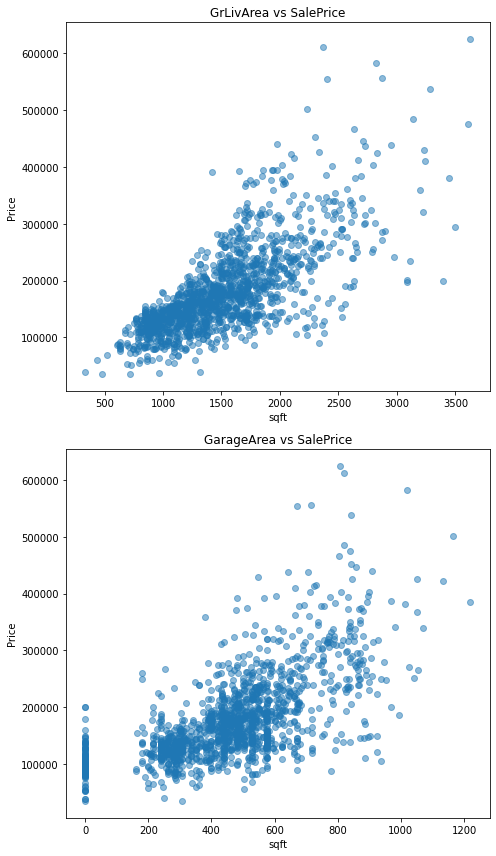

In [14]:
# Check out the linearity again.
visualDetectionOutlier(df)

# One Hot Encoding Categorical Data, Min-Max Scaling, Correlation Matrix

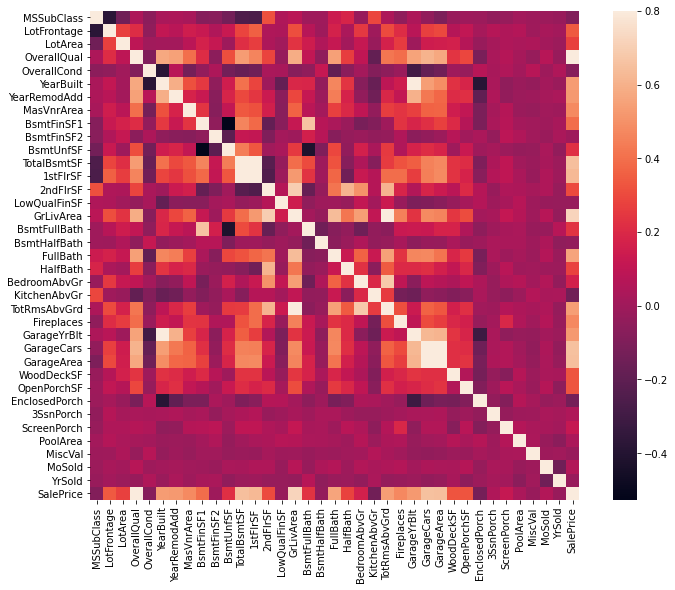

In [15]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [16]:
#Find out which parameters appear to have an appreciable linear relationship with SalePrice
#Arbitrary 0.5 correlation cutoff
print("List of parameters that have a good linear model fit to Sale Price")
# Correlation between SalePrice and other variables.
for i in range(len(corrmat["SalePrice"])-1):
    #Likely to be a linear relationship
    if((corrmat["SalePrice"][i] > 0.5 or corrmat["SalePrice"][i] < -0.5)):
        print(corrmat.columns[i], corrmat["SalePrice"][i])

List of parameters that have a good linear model fit to Sale Price
OverallQual 0.8002198999238866
YearBuilt 0.534894591790901
YearRemodAdd 0.5208853115126126
TotalBsmtSF 0.6466812085464383
1stFlrSF 0.6268726701318775
GrLivArea 0.7216771976009544
FullBath 0.5606284641370038
TotRmsAbvGrd 0.5401086509685642
GarageYrBlt 0.5215241554070832
GarageCars 0.6532628671016962
GarageArea 0.6487457042566283


In [17]:
# Correlation between SalePrice and other variables.
# Sorted from the least to the most correlated.
corrmat.loc['SalePrice'].abs().sort_values()[:-1]

BsmtFinSF2       0.007906
MiscVal          0.019909
YrSold           0.021357
LowQualFinSF     0.025068
PoolArea         0.033230
BsmtHalfBath     0.036153
3SsnPorch        0.048127
MoSold           0.055596
OverallCond      0.079901
MSSubClass       0.086673
ScreenPorch      0.120061
EnclosedPorch    0.130307
KitchenAbvGr     0.140698
BedroomAbvGr     0.163546
BsmtUnfSF        0.221543
BsmtFullBath     0.233879
LotArea          0.272318
HalfBath         0.279980
2ndFlrSF         0.300989
WoodDeckSF       0.324213
OpenPorchSF      0.325154
LotFrontage      0.338856
BsmtFinSF1       0.394263
Fireplaces       0.468391
MasVnrArea       0.478326
YearRemodAdd     0.520885
GarageYrBlt      0.521524
YearBuilt        0.534895
TotRmsAbvGrd     0.540109
FullBath         0.560628
1stFlrSF         0.626873
TotalBsmtSF      0.646681
GarageArea       0.648746
GarageCars       0.653263
GrLivArea        0.721677
OverallQual      0.800220
Name: SalePrice, dtype: float64

In [18]:
# According to the data description, these numeric columns are actually categorical columns.
num_to_cat_list = ['MSSubClass','OverallQual','OverallCond','YearBuilt', 
                             'YearBuilt','YearRemodAdd','MoSold','YrSold']
# Transform numeric data types into string data type.
df[num_to_cat_list] = df[num_to_cat_list].astype(str)

In [19]:
# The data type should be floating point because it indicates sqft.
df['MasVnrArea'] = df['MasVnrArea'].astype(np.float)

In [20]:
# Transform numerical features by scaling each feature to a given range.
categ_df = df.select_dtypes(include=['object'])
numer_df = df.select_dtypes(exclude=['object'])
numer_df = numer_df.drop(columns=['SalePrice'])

#MIN MAX SCALER
scaler = MinMaxScaler()
df[numer_df.columns] = scaler.fit_transform(df[numer_df.columns])

In [21]:
# Pandas One Hot Encoding
df = pd.get_dummies(df, columns=categ_df.columns, prefix=categ_df.columns, drop_first=True)

## Data Splitting

In [22]:
X = df.iloc[:,:456] # defining X and y before splitting the data
X = X.drop(columns=['SalePrice'])
y = df.iloc[:,29] # df.columns.get_loc("SalePrice")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.2)

In [23]:
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
985,0.160959,0.044778,0.000000,0.475320,0.0,0.053082,0.363069,0.286800,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
188,0.147260,0.026726,0.171875,0.496344,0.0,0.000000,0.338740,0.307533,0.000000,0.0,...,0,0,0,0,1,0,1,0,0,0
90,0.133562,0.027577,0.000000,0.000000,0.0,0.000000,0.000000,0.243953,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
84,0.164384,0.033794,0.013750,0.000000,0.0,0.164384,0.119775,0.162405,0.368537,0.0,...,0,0,0,0,1,0,0,0,1,0
508,0.133562,0.038795,0.000000,0.064442,0.0,0.234589,0.214910,0.122668,0.378988,0.0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
y_train.head()

985    125000
188    153337
90     109900
84     168500
508    161000
Name: SalePrice, dtype: int64

## Feature Selection
- Variance Threshold after scaling and one-hot encoding
    - dropped the R^2 score significantly (455 columns --> 38 columns)
- SelectFromModel using Lasso Regression after scaling and one-hot encoding
    - barely changed the R^2 score (455 columns --> 451 columns)
- RFE using Random Forest Regression after scaling and one-hot encoding
    - gives an ordered ranking of most important features to least important features

In [25]:
# Code for SelectFromModel using Lasso Regression is below:

In [26]:
# from sklearn.linear_model import Lasso
# from sklearn.feature_selection import SelectFromModel
# feature_sel_model = SelectFromModel(Lasso(alpha=0.05,random_state=21))
# feature_sel_model.fit(X, y)

# selected_feat = X_train.columns[(feature_sel_model.get_support())]
# print('selected features:',len(selected_feat))
# selected_feat

In [27]:
# df2 = pd.concat([X[selected_feat], y], axis=1)

In [28]:
# defining X and y before splitting the data
# X2 = df2.iloc[:,:451]
# y2 = df2.iloc[:,451] # df.columns.get_loc("SalePrice")
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 21, test_size = 0.2)

In [29]:
# Code for RFE using Random Forest is below:

In [30]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestRegressor

# regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
# regressor.fit(X, y)

# rfe = RFE(regressor, n_features_to_select=1)
# rfe.fit(X, y)

In [31]:
# features = X.columns.values.tolist()

In [32]:
# import operator
# from operator import itemgetter
# for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
#     print(x, y)

In [33]:
# Code for VarianceThreshold is below:

In [34]:
# from sklearn.feature_selection import VarianceThreshold
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# df2 = df
# X2 = df2.iloc[:,:456] # defining X and y before splitting the data
# X2 = X2.drop(columns=['SalePrice'])
# sel.fit_transform(X2)
# # print(sel.fit_transform(X2))
# df2 = df2[df2.columns[sel.get_support(indices=True)]]
# df2.columns.values.tolist()

In [35]:
# df2 = pd.concat([df2, df['SalePrice']], axis=1)

In [36]:
# defining X and y before splitting the data
# X2 = df2.iloc[:,:38]
# y2 = df2.iloc[:,38] # df.columns.get_loc("SalePrice")
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 21, test_size = 0.2)

## Ridge Regression

Testing with original training and testing sets split from df

In [37]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha = 0.5)
ridgeReg.fit(X_train, y_train)
print('Ridge')
print(ridgeReg.score(X_test, y_test)) # returns R^2 score

Ridge
0.9053587893828716


In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import *

cv = KFold(n_splits=10, random_state=21, shuffle=True)

r2_ridge = cross_val_score(ridgeReg, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_ridge = cross_val_score(ridgeReg, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_ridge)
print("\n")
print("Mean R^2 Score:", mean(r2_ridge))
print("\n")
print("MSE:", abs(mse_ridge))
print("\n")
print("Mean MSE Value:", abs(mean(mse_ridge)))

R^2 Score: [0.93390685 0.87611335 0.91096567 0.87382648 0.90970349 0.88481428
 0.91067372 0.87449852 0.90458642 0.91119848]


Mean R^2 Score: 0.8990287260235423


MSE: [4.19609734e+08 5.30360986e+08 5.77307138e+08 5.25021404e+08
 5.58529186e+08 7.56045832e+08 4.47411100e+08 7.68068783e+08
 5.53135374e+08 6.62242473e+08]


Mean MSE Value: 579773201.0358196


Testing with new training and testing sets after feature selection

In [39]:
# ridgeReg2 = Ridge(alpha = 0.5)
# ridgeReg2.fit(X_train2, y_train2)
# print('Ridge')
# print(ridgeReg2.score(X_test2, y_test2))

In [40]:
# r2_ridge2 = cross_val_score(ridgeReg2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_ridge2 = cross_val_score(ridgeReg2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_ridge2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_ridge2))
# print("\n")
# print("MSE:", abs(mse_ridge2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_ridge2)))

## Lasso Regression

Testing with original training and testing sets split from df

In [41]:
from sklearn.linear_model import Lasso
lassoReg = Lasso(alpha = 0.5)
lassoReg.fit(X_train, y_train)
print('Lasso')
print(lassoReg.score(X_test, y_test)) # returns R^2 score

Lasso
0.8914717025028142


/Users/anchal/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127118143403.48778, tolerance: 691623240.1457597
  model = cd_fast.enet_coordinate_descent(


In [42]:
r2_lasso = cross_val_score(lassoReg, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_lasso = cross_val_score(lassoReg, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_lasso)
print("\n")
print("Mean R^2 Score:", mean(r2_lasso))
print("\n")
print("MSE:", abs(mse_lasso))
print("\n")
print("Mean MSE Value:", abs(mean(mse_lasso)))

R^2 Score: [0.92187953 0.86208999 0.90328472 0.86430442 0.90089484 0.84717255
 0.89262804 0.87912685 0.87511775 0.90462706]


Mean R^2 Score: 0.885112575047387


MSE: [4.95968345e+08 5.90395231e+08 6.27111122e+08 5.64643702e+08
 6.13015091e+08 1.00311534e+09 5.37796992e+08 7.39743384e+08
 7.23972340e+08 7.11249273e+08]


Mean MSE Value: 660701081.9418061


Testing with new training and testing sets after feature selection

In [43]:
# lassoReg2 = Lasso(alpha = 0.5)
# lassoReg2.fit(X_train2, y_train2)
# print('Lasso')
# print(lassoReg2.score(X_test2, y_test2))

In [44]:
# r2_lasso2 = cross_val_score(lassoReg2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_lasso2 = cross_val_score(lassoReg2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_lasso2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_lasso2))
# print("\n")
# print("MSE:", abs(mse_lasso2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_lasso2)))

## XGBoost

Testing with original training and testing sets split from df

In [45]:
# !pip install xgboost
from xgboost import XGBRegressor

# XGB = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
print(XGB.score(X_test, y_test))

0.8985280782483196


In [47]:
r2_XGB = cross_val_score(XGB, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_XGB = cross_val_score(XGB, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_XGB)
print("\n")
print("Mean R^2 Score:", mean(r2_XGB))
print("\n")
print("MSE:", abs(mse_XGB))
print("\n")
print("Mean MSE Value:", abs(mean(mse_XGB)))

R^2 Score: [0.88244606 0.87320095 0.85108567 0.87686199 0.8615024  0.90428937
 0.8759493  0.84961334 0.89764429 0.86574054]


Mean R^2 Score: 0.8738333896472396


MSE: [7.46322161e+08 5.42828992e+08 9.65574794e+08 5.12390318e+08
 8.56677133e+08 6.28217004e+08 6.21336281e+08 9.20365987e+08
 5.93380571e+08 1.00124777e+09]


Mean MSE Value: 738834101.5453306


Testing with new training and testing sets after feature selection

In [48]:
# XGB2 = XGBRegressor()
# XGB2.fit(X_train2, y_train2)
# print(XGB2.score(X_test2, y_test2))

In [49]:
# r2_XGB2 = cross_val_score(XGB2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_XGB2 = cross_val_score(XGB2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_XGB2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_XGB2))
# print("\n")
# print("MSE:", abs(mse_XGB2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_XGB2)))

## KNN Regression

Testing with original training and testing sets split from df

In [50]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor()
KNN.fit(X_train,y_train)
print(KNN.score(X_test, y_test))

0.7378623498064758


In [51]:
r2_KNN = cross_val_score(KNN, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_KNN = cross_val_score(KNN, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_KNN)
print("\n")
print("Mean R^2 Score:", mean(r2_KNN))
print("\n")
print("MSE:", abs(mse_KNN))
print("\n")
print("Mean MSE Value:", abs(mean(mse_KNN)))

R^2 Score: [0.75516376 0.71720315 0.78060768 0.72190718 0.71525981 0.81732457
 0.82735886 0.67034498 0.79522505 0.81757501]


Mean R^2 Score: 0.7617970055659906


MSE: [1.55440733e+09 1.21065840e+09 1.42256082e+09 1.15717369e+09
 1.76126089e+09 1.19902883e+09 8.64712567e+08 2.01748795e+09
 1.18712946e+09 1.36044496e+09]


Mean MSE Value: 1373486489.7087648


Testing with new training and testing sets after feature selection

In [52]:
# KNN2 = KNeighborsRegressor()
# KNN2.fit(X_train2, y_train2)
# print(KNN2.score(X_test2, y_test2))

In [53]:
# r2_KNN2 = cross_val_score(KNN2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_KNN2 = cross_val_score(KNN2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_KNN2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_KNN2))
# print("\n")
# print("MSE:", abs(mse_KNN2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_KNN2)))

## Linear Regression

Testing with original training and testing sets split from df

In [54]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.9571065892118549

In [55]:
r2_LR = cross_val_score(LR, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_LR = cross_val_score(LR, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_LR)
print("\n")
print("Mean R^2 Score:", mean(r2_LR))
print("\n")
print("MSE:", abs(mse_LR))
print("\n")
print("Mean MSE Value:", abs(mean(mse_LR)))

R^2 Score: [-2.38425217e+16 -1.21345502e+19 -1.02486878e+18 -5.93569014e+19
 -8.11021379e+19 -9.81480313e+17 -1.03641145e+20 -2.13134272e+17
 -3.49883899e+20 -8.00388556e+00]


Mean R^2 Score: -6.083619593620631e+19


MSE: [1.51370526e+26 5.19482271e+28 6.64534729e+27 2.46990361e+29
 5.01657400e+29 6.44215372e+27 5.19110350e+29 1.30438123e+27
 2.02836083e+30 6.71470008e+10]


Mean MSE Value: 3.362610423020905e+29


Testing with new training and testing sets after feature selection

In [56]:
# LR2 = LinearRegression()
# LR2.fit(X_train2, y_train2)
# LR2.score(X_train2, y_train2)

In [57]:
# r2_LR2 = cross_val_score(LR2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_LR2 = cross_val_score(LR2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_LR2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_LR2))
# print("\n")
# print("MSE:", abs(mse_LR2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_LR2)))

## Random Forest Regression

Testing with original training and testing sets split from df

In [58]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.8978961230199591


In [59]:
r2_rfr = cross_val_score(rfr, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_rfr = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_rfr)
print("\n")
print("Mean R^2 Score:", mean(r2_rfr))
print("\n")
print("MSE:", abs(mse_rfr))
print("\n")
print("Mean MSE Value:", abs(mean(mse_rfr)))

R^2 Score: [0.89471143 0.89273817 0.87145347 0.88657108 0.85401285 0.91684292
 0.88223587 0.86011082 0.89295811 0.87210906]


Mean R^2 Score: 0.8823743788277837


MSE: [6.25258407e+08 4.05714289e+08 8.48847053e+08 4.54253333e+08
 9.49254781e+08 5.63344031e+08 5.44827725e+08 9.32213019e+08
 6.23710484e+08 9.83664957e+08]


Mean MSE Value: 693108807.8632405


Testing with new training and testing sets after feature selection

In [60]:
# rfr2 = RandomForestRegressor()
# rfr2.fit(X_train2, y_train2)
# print(rfr2.score(X_test2, y_test2))

In [61]:
# r2_rfr2 = cross_val_score(rfr2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_rfr2 = cross_val_score(rfr2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_rfr2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_rfr2))
# print("\n")
# print("MSE:", abs(mse_rfr2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_rfr2)))

## SVR

Testing with original training and testing sets split from df

In [62]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

svr = SVR(kernel='linear')
svr.fit(X_train, np.asarray(y_train))
y_pred_svr = svr.predict(X_test)
r2_score(y_test, y_pred_svr)

-0.01908866057047809

In [63]:
r2_svr = cross_val_score(svr, X, y, scoring='r2', cv=cv, n_jobs=-1)
mse_svr = cross_val_score(svr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

print("R^2 Score:", r2_svr)
print("\n")
print("Mean R^2 Score:", mean(r2_svr))
print("\n")
print("MSE:", abs(mse_svr))
print("\n")
print("Mean MSE Value:", abs(mean(mse_svr)))

R^2 Score: [-0.02637214 -0.00707388 -0.00765367  0.0027514  -0.00154652  0.01044408
  0.01850272 -0.07456941 -0.00735306 -0.03524247]


Mean R^2 Score: -0.012811294587724198


MSE: [6.51619371e+09 4.31130133e+09 6.53372288e+09 4.14965715e+09
 6.19506757e+09 6.49515968e+09 4.91605337e+09 6.57636216e+09
 5.83986717e+09 7.72038099e+09]


Mean MSE Value: 5925376602.109986


Testing with new training and testing sets after feature selection

In [64]:
# svr2 = SVR(kernel='linear')
# svr2.fit(X_train2, np.asarray(y_train2))
# y_pred_svr2 = svr2.predict(X_test2)
# r2_score(y_test2, y_pred_svr2)

In [65]:
# r2_svr2 = cross_val_score(svr2, X2, y2, scoring='r2', cv=cv, n_jobs=-1)
# mse_svr2 = cross_val_score(svr2, X2, y2, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# print("R^2 Score:", r2_svr2)
# print("\n")
# print("Mean R^2 Score:", mean(r2_svr2))
# print("\n")
# print("MSE:", abs(mse_svr2))
# print("\n")
# print("Mean MSE Value:", abs(mean(mse_svr2)))

## Notes for ML Algorithms
- So far, cannot find an effective feature selection method (reasons are under "feature selection")
- The MSE values are insanely high; I suspect it's due to underfitting because there are too many features (455)
- For linear regression and SVR, the R^2 values are negative which is technically not possible - eliminate them as methods

## Finding Optimal Hyperparameters

- Using GridSearch to populate optimal hyperparameters for each regression method
- In progress...

# Notes
- Use "df" for the cleaned data 
- Some features, like 'PoolArea', seem to mostly have all the same values. Perhaps worth dropping these as well if too many features for the model?
- Correlation matrix will help with linear regression models

In [66]:
df["PoolArea"].value_counts()

0.000000    1439
0.780488       1
0.693767       1
0.703252       1
0.878049       1
1.000000       1
Name: PoolArea, dtype: int64